In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyscf import gto, scf, fci
from matplotlib.cm import get_cmap
y

import sys
util_dir = "/home/jwdesroches/python/Ga2QuAMES/symmetry/helper_funcs/"
sys.path.append(util_dir)
from utils import *

df = pd.read_csv("/home/jwdesroches/python/Ga2QuAMES/symmetry/summer_2024/exact_diagonalization/results/extracted_data.csv")
df = df.dropna()

In [10]:
def plot_results(mol_name, basis_set, include_FCI=True, include_FCI_comparison=True, include_high_r = False):

    if include_high_r:
        if mol_name == "H2":
            possible_rs = [1,3,5,7]
        elif mol_name == "He2":
            possible_rs = [4,8,12,16]
        else: 
            print("High r values are not available for that molecule.")
            possible_rs = return_r_values(mol_name, "yes")
    else:
        possible_rs = return_r_values(mol_name, "yes")

    if include_FCI:
        fci_bond_lengths = np.linspace(0.3, 5.0, 100)
        fci_energies = []
        for bond_length in fci_bond_lengths:
            mol = gto.Mole()
            mol.build(atom=return_geometry(mol_name, bond_length), basis=basis_set, unit="angstrom")
            mf = scf.RHF(mol)
            mf.kernel()

            cisolver = fci.FCI(mf)
            fci_energy = cisolver.kernel()[0]
            fci_energies.append(fci_energy)

    if include_FCI_comparison:
        fci_bond_lengths_comp = np.around(np.arange(0.3, 5.0, 0.1), 2)
        sym_diffs_dict = {r: [] for r in possible_rs}
        nosym_diffs_dict = {r: [] for r in possible_rs}
        for bond_length in fci_bond_lengths_comp:
            try:
                mol = gto.Mole()
                mol.build(atom=return_geometry(mol_name, bond_length), basis=basis_set, unit="angstrom")
                mf = scf.RHF(mol)
                mf.kernel()

                cisolver = fci.FCI(mf)
                fci_energy = cisolver.kernel()[0]
            except Exception as e:
                fci_energy = np.nan
            
            for r in possible_rs:
                sym_diff = df["Ising Energy [Hartree]"][(df["Molecule"] == mol_name) & 
                                                        (df["Basis Set"] == basis_set) & 
                                                        (df["Symmetry Case"] == "yes") & 
                                                        (df["R value"] == r) & 
                                                        (df["Bond Length"] == bond_length)].values
                nosym_diff = df["Ising Energy [Hartree]"][(df["Molecule"] == mol_name) & 
                                                        (df["Basis Set"] == basis_set) & 
                                                        (df["Symmetry Case"] == "no") & 
                                                        (df["R value"] == r) & 
                                                        (df["Bond Length"] == bond_length)].values
                
                sym_diff = sym_diff[0] - fci_energy if sym_diff.size > 0 else np.nan
                nosym_diff = nosym_diff[0] - fci_energy if nosym_diff.size > 0 else np.nan
                
                sym_diffs_dict[r].append(sym_diff)
                nosym_diffs_dict[r].append(nosym_diff)

    fig, axs = plt.subplots(nrows=1, ncols=len(possible_rs), figsize=(7* len(possible_rs), 5), sharex=True, sharey=True)
    if len(possible_rs) == 1:
        axs = [axs]
    
    if include_FCI_comparison:
        fig_diffs, axs_diffs = plt.subplots(nrows=1, ncols=len(possible_rs), figsize=(7 * len(possible_rs), 2), sharex=True, sharey=True)
        if len(possible_rs) == 1:
            axs_diffs = [axs_diffs]
        else:
            axs_diffs = axs_diffs.flatten()
    
    for i, r in enumerate(possible_rs):
        ax = axs[i]
        
        ax.plot(df["Bond Length"][(df["Molecule"] == mol_name) & (df["Basis Set"] == basis_set) & 
                    (df["Symmetry Case"] == "yes") & (df["R value"] == r)], 
                df["Ising Energy [Hartree]"][(df["Molecule"] == mol_name) & (df["Basis Set"] == basis_set) & 
                    (df["Symmetry Case"] == "yes") & (df["R value"] == r)], ".r", label="w/ Sym")

        if len(df["Ising Energy [Hartree]"][(df["Molecule"] == mol_name) & (df["Basis Set"] == basis_set) & 
                    (df["Symmetry Case"] == "no") & (df["R value"] == r)]) != 0:
        
            ax.plot(df["Bond Length"][(df["Molecule"] == mol_name) & (df["Basis Set"] == basis_set) & 
                        (df["Symmetry Case"] == "no") & (df["R value"] == r)], 
                    df["Ising Energy [Hartree]"][(df["Molecule"] == mol_name) & (df["Basis Set"] == basis_set) & 
                        (df["Symmetry Case"] == "no") & (df["R value"] == r)], "xb", markersize = 5, label="w/o Sym")
        
        ax.text(0.5, 0.925, f"$r=${r}", transform=ax.transAxes, fontsize=12, verticalalignment="top", 
                bbox=dict(boxstyle='square,pad=0.3', edgecolor='black', facecolor='white'))
        
        if include_FCI:
            ax.plot(fci_bond_lengths, fci_energies, '-k', label="FCI [RHF]")
        
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
                  ncol=3, fancybox=True, shadow=True)
        
        ax.set_xlabel("Bond Length [$\AA$]")
        ax.set_ylabel("Energy [$E_h$]")
        ax.grid()
        ax.set_xlim(0.2, 5.1)
        
        if include_FCI_comparison:
            sym_diffs = sym_diffs_dict[r]
            nosym_diffs = nosym_diffs_dict[r]
            axs_diffs[i].plot(fci_bond_lengths_comp, np.abs(sym_diffs), '.r', label="w/ Sym")
            axs_diffs[i].plot(fci_bond_lengths_comp, np.abs(nosym_diffs), 'xb', markersize = 5, label="w/o Sym")
            axs_diffs[i].set_xlabel("Bond Length [$\AA$]")
            axs_diffs[i].set_ylabel("$\Delta E$ [$E_h$]")
            axs_diffs[i].grid()
            axs_diffs[i].set_xlim(0.2, 5.1)
            axs_diffs[i].set_ylim(-0.05,0.4)

    fig.tight_layout()
    if include_FCI_comparison:
        fig_diffs.tight_layout()
    plt.show()

    return None

/tmp/ipykernel_734678/3122760447.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("gist_rainbow", len([1,2,3,4,5,6,7,8]))


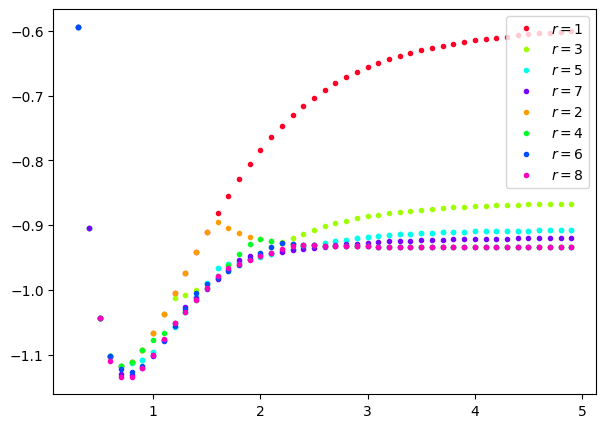

In [15]:
mol_name = "H2"
basis_set = "sto-3g"

fig, ax = plt.subplots(figsize = (7,5))

cmap = get_cmap("gist_rainbow", len([1,2,3,4,5,6,7,8]))

for r in [1,3,5,7]:
    ax.plot(df["Bond Length"][(df["Molecule"] == mol_name) & (df["Basis Set"] == basis_set) & 
                    (df["Symmetry Case"] == "yes") & (df["R value"] == r)], 
                df["Ising Energy [Hartree]"][(df["Molecule"] == mol_name) & (df["Basis Set"] == basis_set) & 
                    (df["Symmetry Case"] == "yes") & (df["R value"] == r)], '.', color = cmap(r-1), label="$r=$"+f"{r}")
    

for r in [2,4,6,8]:
    ax.plot(df["Bond Length"][(df["Molecule"] == mol_name) & (df["Basis Set"] == basis_set) & 
                    (df["Symmetry Case"] == "yes") & (df["R value"] == r)], 
                df["Ising Energy [Hartree]"][(df["Molecule"] == mol_name) & (df["Basis Set"] == basis_set) & 
                    (df["Symmetry Case"] == "yes") & (df["R value"] == r)], '.' , color = cmap(r-1),label="$r=$"+f"{r}")
    
ax.legend()
fci_bond_lengths = np.linspace(0.3, 5.0, 100)
fci_energies = []
for bond_length in fci_bond_lengths:
    mol = gto.Mole()
    mol.build(atom=return_geometry(mol_name, bond_length), basis=basis_set, unit="angstrom")
    mf = scf.RHF(mol)
    mf.kernel()

    cisolver = fci.FCI(mf)
    fci_energy = cisolver.kernel()[0]
    fci_energies.append(fci_energy)